# USGS Chapter 3 Describing Uncertainty

In [231]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## Confidence Intervals

### Normal Distribution Generated Confidence Intervals

In [232]:
def generate_data( mu=5, sigma=1, random_function=np.random.normal, n=12, iterations=10):
    outMatrix = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
    xs = {}
    df = n - 1
    for i in range(iterations):
        x = random_function(mu, sigma , size=12)
        xs[i] = x
        xbar = np.mean(x)
        xvar = np.var(x)
        stdev = np.sqrt(xvar)
        lcl = xbar + st.t.ppf(0.05, df) * np.sqrt(xvar / n)
        ucl = xbar + st.t.ppf(0.95, df) * np.sqrt(xvar / n)
        outMatrix.loc[i,:] = [xbar, stdev, lcl, ucl]

    return outMatrix, xs

In [233]:
# generate data with defaults
norm_results, norm_xs = generate_data()
norm_results


,xbar,sd,lcl,ucl
0,4.942844,0.828226,4.513469,5.372219
1,4.810582,1.013103,4.285362,5.335802
2,5.26232,1.125411,4.678877,5.845764
3,4.66457,0.860447,4.218491,5.110649
4,5.056466,1.052693,4.510721,5.602211
5,4.95037,1.010567,4.426464,5.474275
6,4.368833,0.80357,3.95224,4.785425
7,4.550124,0.929618,4.068184,5.032063
8,4.896642,0.617278,4.576629,5.216656
9,4.732214,0.938267,4.245791,5.218637


In [255]:
def plot_replicates(df_results, 
                    vline=5, 
                    title = f"90% Confidence Intervals on the Mean for Randomly Generated\nNormally Distributed Data, n={n}", 
                    xlim=(3,7), ylim=None, annotate=None):
    fig, ax = plt.subplots()
    for row in df_results.index:
        ax.scatter(df_results.at[row,'xbar'], row, c='black')
        ax.hlines(row, df_results.at[row,'lcl'], df_results.at[row,'ucl'],color='black')
        if annotate:
            ax.text(df_results.at[row,'ucl']+0.1, row, annotate[row])
    ax.axvline(vline, color='black', linestyle ='dashed')
    ax.set_title(title, size=16)
    ax.set_xlabel('Chloride (mg/L)')
    ax.set_ylabel('Replicate')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

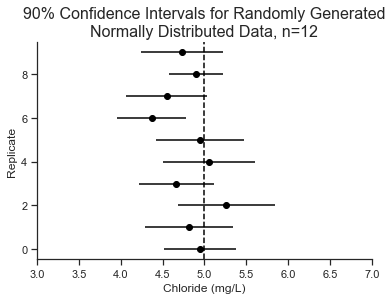

In [256]:
plot_replicates(norm_results)

### Log-normal Distribution - Generated Confidence Intervals

In [257]:
lnorm_results, lnorm_xs = generate_data(mu=-.5, sigma=1, random_function=np.random.lognormal)
lnorm_results

,xbar,sd,lcl,ucl
0,0.577489,0.5356,0.299819,0.855159
1,1.014857,0.913056,0.541504,1.48821
2,1.357606,0.96774,0.855903,1.859309
3,0.650696,0.329216,0.480022,0.821371
4,1.117556,0.90296,0.649436,1.585675
5,0.689476,0.446518,0.457989,0.920963
6,0.981952,0.674977,0.632025,1.331878
7,0.734663,0.54864,0.450233,1.019093
8,0.923918,0.520944,0.653846,1.193989
9,0.6605,0.390254,0.458182,0.862819


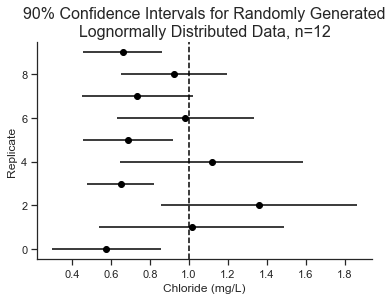

In [259]:
plot_replicates(lnorm_results, vline=1, xlim=None,
                title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


# Bayesian Way

In [238]:
import pymc3 as pm
import bambi as bmb
import arviz as az

Let's just use one replicate dataset

In [376]:
with pm.Model() as m1_univariate_normal:
    concentrations = pm.Data('concentrations', norm_xs[0])
    sigma  = pm.HalfFlat('sigma')
    mu = pm.HalfFlat('mu')
    pm.Normal('predicted concentration', mu, sigma, observed=concentrations)
    m1_idata = pm.sample(return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [377]:
m1_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [383]:
with m1_univariate_normal:
    post_pred = pm.fast_sample_posterior_predictive(m1_idata, 1000)

In [ ]:
m1_idata

In [379]:
posterior_pred

{'predicted concentration': array([[5.46899203, 5.7782765 , 6.75184864, ..., 6.8677349 , 7.12033831,
         6.51082809],
        [3.41517705, 3.65234211, 2.47854873, ..., 3.51864493, 3.83394364,
         2.902733  ],
        [4.92529597, 5.45660684, 4.31618263, ..., 3.86474669, 4.45307011,
         5.54708592],
        ...,
        [5.68264975, 5.32736443, 3.70705049, ..., 6.23239923, 3.1069025 ,
         5.16045923],
        [4.7147992 , 5.41206762, 5.00263016, ..., 4.58014552, 3.47189296,
         1.04114999],
        [3.32917364, 2.5610622 , 3.84335731, ..., 3.24876609, 4.25782418,
         4.5565439 ]])}

In [324]:
def plot_data_trace_dists(data = norm_xs[0], posterior=posterior, posterior_pred=posterior_pred, plot_n = 200,
                    x_axis = np.arange(0, 10, 0.001), xlim=(0,12),
                    title='Data Histogram, Analytical and Bayesian Distribution Fits' ):
    fig, ax = plt.subplots()
    sns.histplot(data, bins=10, stat='density', ax=ax, label='Data')
    post_df_sam  = posterior.posterior.to_dataframe().sample(plot_n).reset_index(drop=True)
    for row in post_df_sam.index:
        ax.plot(x_axis, 
                st.norm.pdf(x_axis, post_df_sam.at[row, 'mu'], post_df_sam.at[row, 'sigma']), 
                color='black', alpha=.08)
    
    sns.kdeplot(posterior_pred['predicted concentration'].flatten(),ax=ax, lw=5,
                color='orange', label='Posterior Predictive (Bayes)')
    ax.plot(x_axis, 
                st.t.pdf(x_axis, df = 12-1, loc=data.mean(), scale=data.std()), 
                color='lime', 
                label='T Distribution for Data (Analytical)')
    ax.set_xlim(xlim)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, size=16, loc='left')


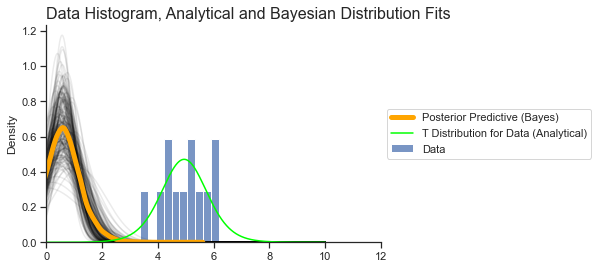

In [325]:
plot_data_trace_dists()

Text(0, 0.5, '')

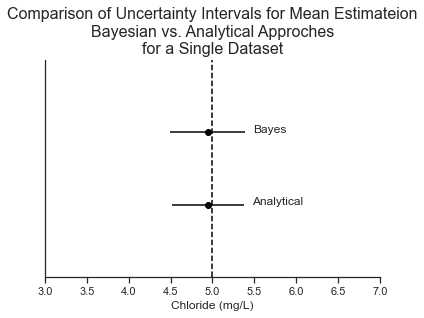

In [313]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = norm_results.loc[0]
mus = posterior.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], 
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# Compare to Lognormal Data

In [317]:
with univariate_normal:
    pm.set_data({'concentrations': lnorm_xs[0]})
    posterior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7168531053240152, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [318]:
with univariate_normal:
    posterior_pred = pm.sample_posterior_predictive(posterior, 1000)

C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


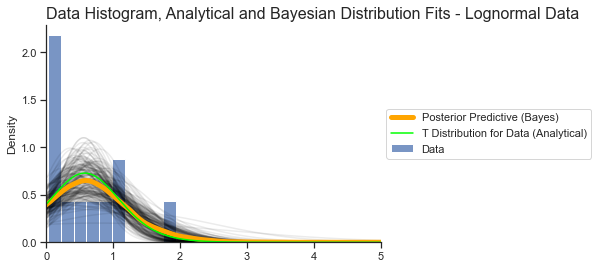

In [326]:
plot_data_trace_dists(data = lnorm_xs[0], xlim=(0,5), posterior=posterior, posterior_pred=posterior_pred,
                    title='Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Data' )

Text(0, 0.5, '')

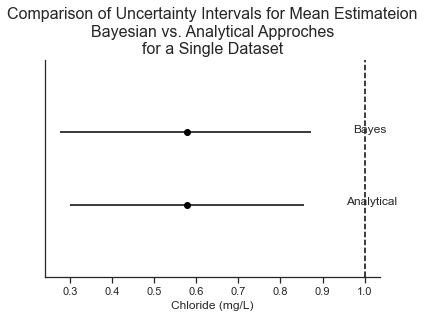

In [333]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = lnorm_results.loc[0]
mus = posterior.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], xlim=None, vline=1,
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# Lognormal 

Not sure why no lognormal for PM3 

In [335]:
with pm.Model() as univariate_lnormal:
    concentrations = pm.Data('concentrations', lnorm_xs[0])
    sigma  = pm.HalfFlat('sigma')
    mu = pm.HalfFlat('mu')
    pm.Lognormal('predicted concentration', mu, sigma, observed=concentrations)

WARNING (theano.link.c.cmodule): Removing key file C:\Users\gbrunkhorst\AppData\Local\Theano\compiledir_Windows-10-10.0.19044-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIntel-3.9.7-64\tmp09nkdbes\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file C:\Users\gbrunkhorst\AppData\Local\Theano\compiledir_Windows-10-10.0.19044-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIntel-3.9.7-64\tmp0ftpj70a\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file C:\Users\gbrunkhorst\AppData\Local\Theano\compiledir_Windows-10-10.0.19044-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIntel-3.9.7-64\tmp0ol6gmpw\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file C:\Users\gbrunkhorst\AppData\Local\Theano\compiledir_Windows-10-10.0.19044-SP0-Intel64_Family_6_Model_142_Stepping_10_GenuineIn

In [338]:
with univariate_lnormal:
    posterior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [337]:
with univariate_lnormal:
    posterior_pred = pm.sample_posterior_predictive(posterior, 1000)

C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


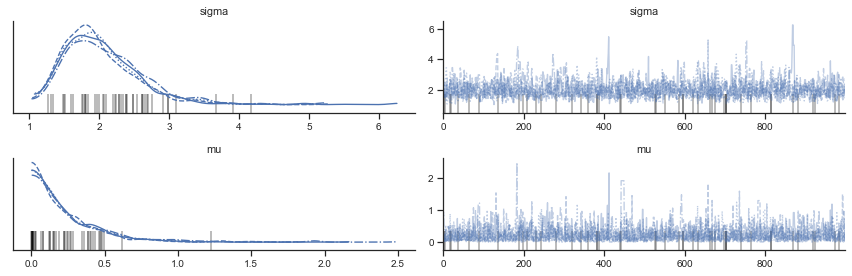

In [341]:
az.plot_trace(posterior)
plt.tight_layout();

In [342]:
az.summary(posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.031,0.547,1.163,2.961,0.017,0.012,1283.0,937.0,1.01
mu,0.237,0.246,0.000,0.639,0.007,0.005,1385.0,1582.0,1.00


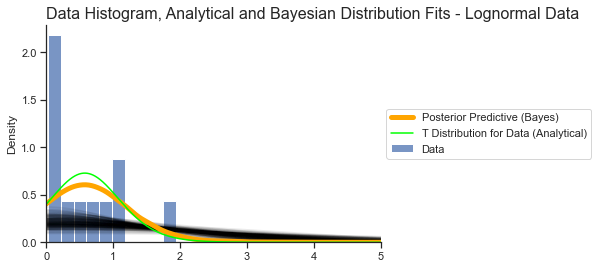

In [362]:
plot_data_trace_dists(data = lnorm_xs[0], xlim=(0,5), posterior=posterior, posterior_pred=posterior_pred,
                    title='Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Data' )

In [369]:
posterior_pred['predicted concentration'].mean(axis=1)

array([ 7.47913227e-01,  1.42583171e-01, -5.46825557e-01,  8.69062734e-01,
       -6.70124165e-02, -1.18661137e-01,  3.67390882e-01,  7.07247766e-01,
        5.75509749e-01,  6.97627763e-01,  5.12206775e-01,  7.19075107e-01,
        6.00787394e-01,  7.54600190e-01,  6.56913741e-01,  1.23906447e+00,
        4.97691648e-01,  7.82610226e-01,  1.65093356e-01,  4.01392406e-02,
        8.06704691e-01,  1.01069231e+00,  4.71844563e-01,  5.25196875e-01,
        3.59947416e-01,  9.87460845e-01,  4.33129191e-01,  2.32772716e-01,
        3.19143149e-01,  5.57664705e-01,  3.32509524e-01,  6.63886878e-01,
        7.94967467e-01,  7.47542347e-01,  2.75316220e-01,  1.05889705e+00,
        6.97601090e-01,  6.59300803e-01,  1.20621986e+00,  1.06275683e+00,
        8.84048292e-01,  4.66199083e-01,  5.44370586e-01,  3.76117317e-01,
        9.31198580e-01,  7.77796611e-01,  4.67474456e-01,  9.59856049e-01,
        8.87280789e-01,  6.61720914e-01,  6.81554500e-01,  6.46641972e-01,
        6.60380672e-01,  

Text(0, 0.5, '')

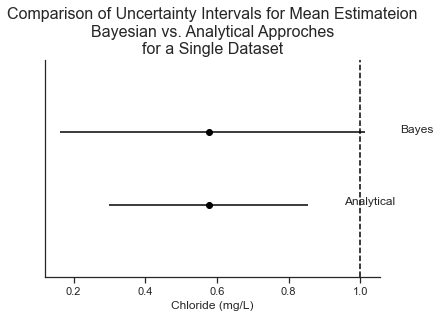

In [370]:
# based on posterior predictive
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = lnorm_results.loc[0]
mus = posterior_pred['predicted concentration'].mean(axis=1)
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], xlim=None, vline=1,
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

Text(0, 0.5, '')

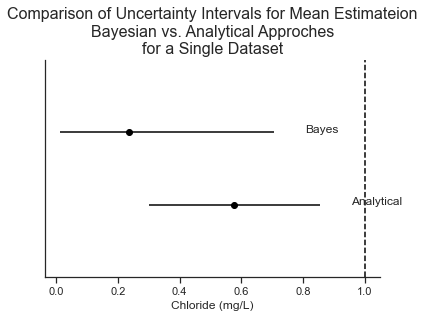

In [375]:
# based on mus - the conversion seems a bit strange.  
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = lnorm_results.loc[0]
mus = (posterior.posterior['mu'].values)
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], xlim=None, vline=1,
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# Bayesian ProUCL

# Constructing Confidence Intervals on Percentiles

In [ ]:
with univariate_normal:
    posterior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
The acceptance probability does not match the target. It is 0.8797337620465219, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
with univariate_normal:
    posterior_pred = pm.sample_posterior_predictive(posterior, 1000)

C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
def plot_data_trace_dists(data = norm_xs[0], posterior=posterior, posterior_pred=posterior_pred, plot_n = 200,
                    x_axis = np.arange(0, 10, 0.001), xlim=(0,12),
                    title='Data Histogram, Analytical and Bayesian Distribution Fits' ):
    fig, ax = plt.subplots()
    sns.histplot(data, bins=10, stat='density', ax=ax, label='Data')
    post_df_sam  = posterior.posterior.to_dataframe().sample(plot_n).reset_index(drop=True)
    for row in post_df_sam.index:
        ax.plot(x_axis, 
                st.norm.pdf(x_axis, post_df_sam.at[row, 'mu'], post_df_sam.at[row, 'sigma']), 
                color='black', alpha=.08)
    
    sns.kdeplot(posterior_pred['predicted concentration'].flatten(),ax=ax, lw=5,
                color='orange', label='Posterior Predictive (Bayes)')
    ax.plot(x_axis, 
                st.t.pdf(x_axis, df = 12-1, loc=data.mean(), scale=data.std()), 
                color='lime', 
                label='T Distribution for Data (Analytical)')
    ax.set_xlim(xlim)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, size=16)


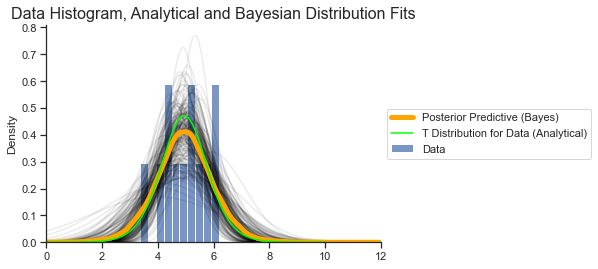

In [ ]:
plot_data_trace_dists()

Text(0, 0.5, '')

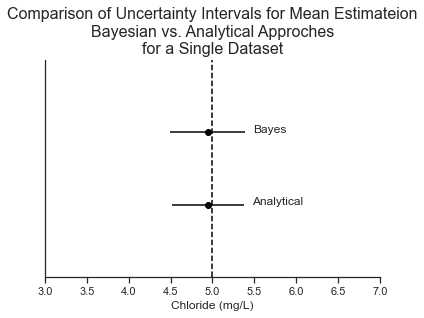

In [ ]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = norm_results.loc[0]
mus = posterior.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], 
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

In [ ]:
with univariate_normal:
    posterior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
The acceptance probability does not match the target. It is 0.8797337620465219, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
with univariate_normal:
    posterior_pred = pm.sample_posterior_predictive(posterior, 1000)

C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
def plot_data_trace_dists(data = norm_xs[0], posterior=posterior, posterior_pred=posterior_pred, plot_n = 200,
                    x_axis = np.arange(0, 10, 0.001), xlim=(0,12),
                    title='Data Histogram, Analytical and Bayesian Distribution Fits' ):
    fig, ax = plt.subplots()
    sns.histplot(data, bins=10, stat='density', ax=ax, label='Data')
    post_df_sam  = posterior.posterior.to_dataframe().sample(plot_n).reset_index(drop=True)
    for row in post_df_sam.index:
        ax.plot(x_axis, 
                st.norm.pdf(x_axis, post_df_sam.at[row, 'mu'], post_df_sam.at[row, 'sigma']), 
                color='black', alpha=.08)
    
    sns.kdeplot(posterior_pred['predicted concentration'].flatten(),ax=ax, lw=5,
                color='orange', label='Posterior Predictive (Bayes)')
    ax.plot(x_axis, 
                st.t.pdf(x_axis, df = 12-1, loc=data.mean(), scale=data.std()), 
                color='lime', 
                label='T Distribution for Data (Analytical)')
    ax.set_xlim(xlim)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, size=16)


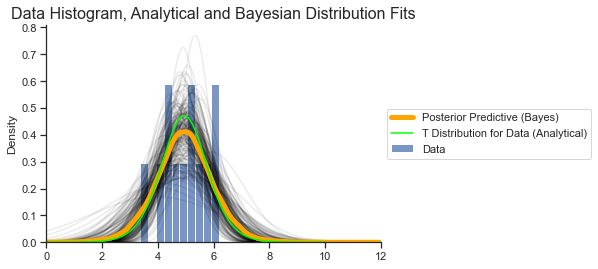

In [ ]:
plot_data_trace_dists()

Text(0, 0.5, '')

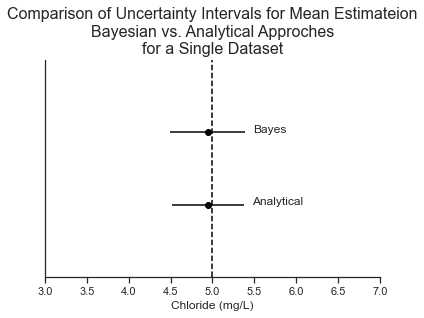

In [ ]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = norm_results.loc[0]
mus = posterior.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], 
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# ARVIZ Code didn't apply above

Text(0, 0.5, 'Trial')

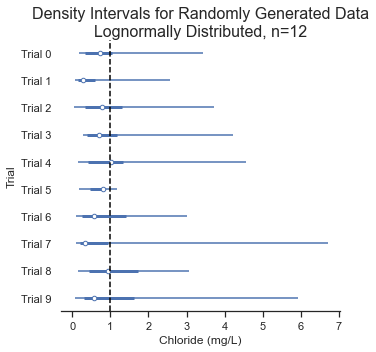

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
az.plot_forest(xs, ax=ax)

ax.axvline(1, color='black', linestyle ='dashed')
ax.set_title(f"Density Intervals for Randomly Generated Data\nLognormally Distributed, n={n}", size=16)
ax.set_xlabel('Chloride (mg/L)')
ax.set_ylabel('Trial')